In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd
import math
from PIL import Image
from scipy.misc import imread

In [5]:
#Function that takes an image and corrupts it with Gaussian noise
def add_gaussian_noise(img,prop,varSigma):
    N = int(np.round(np.prod(img.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(img.shape))[1:N],img.shape)
    e = varSigma*np.random.randn(np.prod(img.shape)).reshape(img.shape)
    img1 = np.copy(img)
    img1[index] += e[index]
    img1 *= (1.0/img1.max())
    w, h = img.shape
    for i in range(w):
        for j in range(h):
            if img1[i, j] < 0:
                img1[i, j] = 0
            elif img1[i, j] > 1:
                img1[i, j] = 1
    return img1

#Function that takes an image and flips bits randomly with a probability 'prop'
def add_saltnpepper_noise(img,prop):
    N = int(np.round(np.prod(img.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(img.shape))[1:N],img.shape)
    img2 = np.copy(img)
    img2[index] = 1 - img2[index]
    
    return img2

/home/jake/miniconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


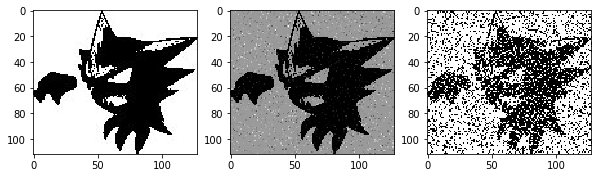

In [87]:
#proportion of pixels to alter
prop = 0.2
varSigma = 0.2

#Reading in image and normalising pixel values
# img = imread('stanGray')
# img = imread('chessBW.png')
img = imread('H.jpg')
img = img/255

#Visualising uncorrupted image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(131)
ax.imshow(img, cmap = 'gray')

#Visualising image corrupted with Gaussian noise
img1 = add_gaussian_noise(img, prop, varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(img1,cmap = 'gray')

#Visualising the image corrupter with salt and pepper noise
img2 = add_saltnpepper_noise(img, prop)
ax3 = fig.add_subplot(133)
ax3.imshow(img2,cmap = 'gray')

plt.show()

imgx = 2 * (img) - 1
img1x = 2 * (img1) - 1
img2x = 2 * (img2) - 1

In [7]:
#Defining a function that takes a given pixel and returns a list of the pixels around it.
#M is the number of rows. N is the number of columns. Size determines whether or not we consider diagonal pixels
def neighbours(i,j,M,N,size):
    if size==4: #not considering diagonal pixels
        if(i==0 and j==0): #top left corner
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1: #top right corner
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0: #bottom left corner
            n=[(M-1,1), (M-2,0)]
        elif i==0 and j==N-1: #bottom right corner
            n=[(M-1,N-2), (M-2,N-1)]
        elif i == 0: #first row not corner
            n= [(0,j-1), (0,j+1), (1,j)]
        elif i==M-1: #bottom row not corner
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0: #first column not corner
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        elif j==N-1: #last column not corner
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else: #centre pixels
            n = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        
    if size==8: #also considers the diagonal pixels
        if (i==0) and (j==0): #top left
            n=[(i,1),      (1, j)]
        elif i==0 and j==N-1: #top right
            n=[(0, N-2),   (1, N-1),   (1, N-2)]
        elif i==M-1 and j==0: #bottom left
            n=[(M-1, 1),   (M-2, 0),   (M-2, 1)]
        elif i==M-1 and j==N-1: #bottom right
            n=[(M-1, N-2), (M-2, N-1), (M-2, N-2)]
        elif i==0: #first row
            n=[(0, j+1),   (0, j-1),   (1, j),     (1, j-1),   (1, j+1)]
        elif i==M-1: #last row
            n=[(i, j+1),   (i, j-1),   (i-1, j),   (i-1, j+1), (i-1, j-1)]
        elif j==0: #first column
            n=[(i-1, j),   (i+1, j),   (i-1, j+1), (i, j+1),   (i+1, j+1)]
        elif j==N-1: #last column
            n=[(i-1, j),   (i+1, j),   (i-1, j-1), (i, j-1),   (i+1, j-1)]
        else: #centre 
            n=[(i-1, j-1), (i, j-1),   (i+1, j-1), (i-1, j),   (i+1, j),  (i-1, j+1), (i, j+1),   (i+1, j+1)]
        
        return n
        #returns the indexes of the neighbours
        
def percentageMatch(img1, img2):
    w, h = img1.shape
    match = 0
    for i in range(w):
        for j in range(h):
            if img1[i, j] == img2[i, j]:
                match += 1
    return round(100 * match / (w*h), 2)

def percentageMatchStr(img1, img2):
    return str(percentageMatch(img1, img2))+'%'

### ICM Definition

In [110]:
#update pixel function for ICM
def update_pixel(image,i,j,M,N, eta, beta):
    
    #getting neighbours for the node
    nbrhd = neighbours(i,j,M,N,8)
    #size of neighbourhood
    size = np.shape(nbrhd)[0]
    
    #initialising array of zeroes
    nbrhd_values = np.zeros(size)
    
    #Inserting values into array initialised above
    for k in range (size):
        nbrhd_values[k] = image[nbrhd[k]]
        
    centrePixel = image[i,j]
    
    pxminusone = eta * (centrePixel) * (-1)
    pxone = eta * (centrePixel)
    
    for value in nbrhd_values:
        pxone += beta * (value * 1)
        pxminusone += beta * (value * (-1))
    
    #initialising pxlValue
    pxlValue = centrePixel
    
    #comparing pxone and pxminus one and then updating the pxlValue
    if (pxone > pxminusone):
        pxlValue = 1
    elif (pxone < pxminusone):
        pxlValue = -1

    return pxlValue


def badUpdatePixel(image,i,j,M,N,size):
    #getting neighbours for the node
    nbrhd = neighbours(i,j,M,N,8)
    
    #size of neighbourhood
    size = np.shape(nbrhd)[0]
    
    #initialising array of zeroes
    nbrhd_values = np.zeros(size)
    
    #Inserting values into array initialised above
    for k in range (size):
        nbrhd_values[k] = image[nbrhd[k]]
    
    s = sum(nbrhd_values)/size
    
    if (s >= 0.5):
        return 1
    else:
        return 0

def ICM (image, t):
    
    eta = 4
    beta = 2.35
    x = image.copy()
    y = image.copy()
    
    M = np.shape(image)[0]
    N = np.shape(image)[1]
    
    cleanSimilarity = []
    noisySimilarity = []
    changes = 0
    counter = []
    
    for r in range (t):
        changes = 0
        cleanSimilarity.append(percentageMatch(x, imgx))
        noisySimilarity.append(percentageMatch(x, image))
        for i in range (M):
                for j in range(N):
                    old = x[i, j]
                    x[i,j] = update_pixel(y,i,j,M,N,eta,beta)
#                     x[i,j] = badUpdatePixel(y,i,j,M,N,8)
                    if old != x[i,j]:
                        changes += 1
        counter.append(changes)
        
        y = x.copy()
    
    return y, cleanSimilarity, noisySimilarity, counter

### ICM drawer

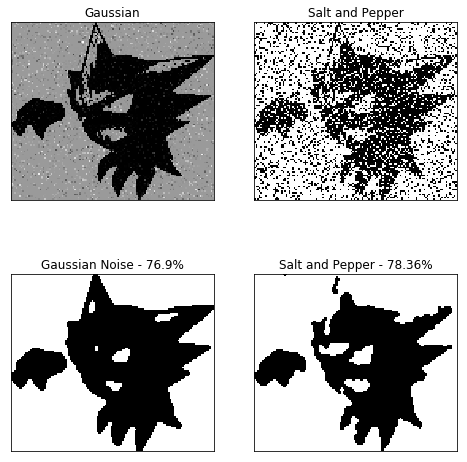

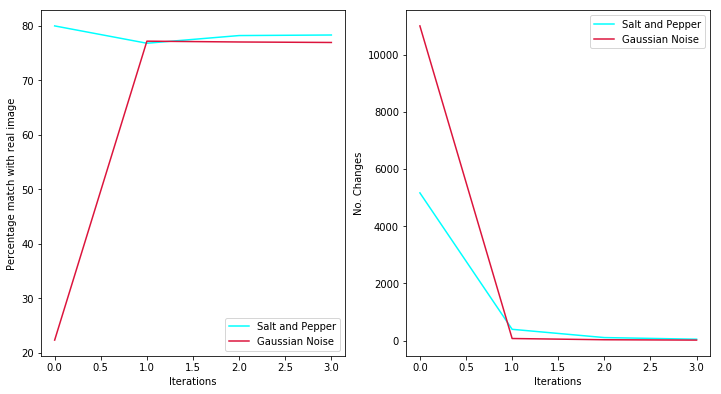

In [111]:
denoisedSP = ICM(img2x, 4)
denoisedGauss = ICM(img1x, 4)

iterate = 4

fig =plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom = 0.2, top = 1)
ax1 = fig.add_subplot(221)
ax1.imshow(img1, cmap='gray')
ax1.set_title('Gaussian')
ax1.set_yticks([])
ax1.set_xticks([])
ax2 = fig.add_subplot(222)
ax2.imshow(img2, cmap='gray')
ax2.set_title('Salt and Pepper')
ax2.set_yticks([])
ax2.set_xticks([])
ax3 = fig.add_subplot(223)
ax3.imshow(denoisedGauss[0], cmap='gray')
ax3.set_title('Gaussian Noise - ' + percentageMatchStr(imgx, denoisedGauss[0]))
ax3.set_yticks([])
ax3.set_xticks([])
ax4 = fig.add_subplot(224)
ax4.imshow(denoisedSP[0], cmap='gray')
ax4.set_title('Salt and Pepper - ' + percentageMatchStr(imgx, denoisedSP[0]))
ax4.set_yticks([])
ax4.set_xticks([])
plt.show()

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom = 0.2, top = 1)
ax1 = fig.add_subplot(121)
ax1.plot(list(range(iterate)), denoisedSP[1], c='cyan', label='Salt and Pepper')
ax1.plot(list(range(iterate)), denoisedGauss[1], c='crimson', label='Gaussian Noise')
ax1.legend()
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Percentage match with real image')

ax2 = fig.add_subplot(122)
ax2.plot(list(range(iterate)), denoisedSP[3], c = 'cyan', label = 'Salt and Pepper')
ax2.plot(list(range(iterate)), denoisedGauss[3], c = 'crimson', label = 'Gaussian Noise')
ax2.legend()
ax2.set_xlabel('Iterations')
ax2.set_ylabel('No. Changes')
plt.show()


#### Gibb definition

In [117]:
def gibbPrior(img, i, j, M, N, val, beta):
    nbrhd = neighbours(i,j,M,N,8)
    prior = 0
    for pt in nbrhd:
        prior += val * img[pt]
    return math.exp(prior * beta)

def prob(x, y, i, j, M, N, beta, eta):
    p = gibbPrior(x, i, j, M, N, 1, beta) * gibbLikelihood(y[i, j], 1, eta)
    n = gibbPrior(x, i, j, M, N, -1, beta) * gibbLikelihood(y[i, j], -1, eta)
    return p / (p + n)

def Li(yi, xi):
    if (xi == 1):
        xi = 1.1
    else:
        xi = -0.1
    return 1 / (abs(yi - xi))

def gibbLikelihood(yi, xi, eta):
    return math.exp(Li(yi, xi) * eta)

def Gibbs(image, t, beta, eta, iterOrder = 0, realIm = None):
    y = image.copy()
    x = image.copy()
    xNew = image.copy()
    
    counterArray = []
    cleanSimilarity = []
    
    M = np.shape(image)[0]
    N = np.shape(image)[1]
    
    for k in range(t):
        if not realIm is None:
            cleanSimilarity.append(percentageMatch(x, realIm))
        counter = 0
        
        iList = list(range(M)) ## make these M and N see if different is heopfully different
        jList = list(range(N))
        if iterOrder == 1:
            random.shuffle(iList)
            random.shuffle(jList)
        elif iterOrder ==2:
            iList = [random.randint(0, M - 1) for i in range(M)]
            jList = [random.randint(0, N - 1) for i in range(N)]
        
        for i in iList:
            for j in jList:
                uniform = np.random.rand()
               
                if prob(x, y, i, j, M, N, beta, eta) > uniform:
                    xNew[i,j] = 1
                else:
                    xNew[i,j] = 0
                
                if (xNew[i, j] != x[i, j]):
                    counter = counter + 1
        
        x = xNew.copy()
        counterArray.append(counter)
        
    return x, cleanSimilarity, counterArray

### Method comparison graph

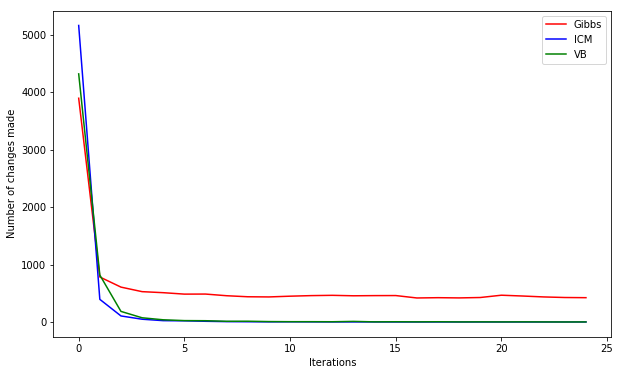

In [124]:
noisyImage = img2
iterate = 25
beta = 0.8
eta = 1

# Ggauss  = Gibbs(noisyImage, iterate, beta, eta, 0, img)
# denoisedSP = ICM(img2x, iterate)
# # denoisedGauss = ICM(img1x, iterate)
# VB = meanField(noisyImage, iterate, 1, 1.1, img)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(list(range(iterate)), Ggauss[2]      , c='r', label='Gibbs')
ax.plot(list(range(iterate)), denoisedSP[3], c='b', label='ICM')
ax.plot(list(range(iterate)), VB[0], c='g', label='VB')

ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Number of changes made')
plt.savefig('AllComparisonChanges.png')
plt.show()

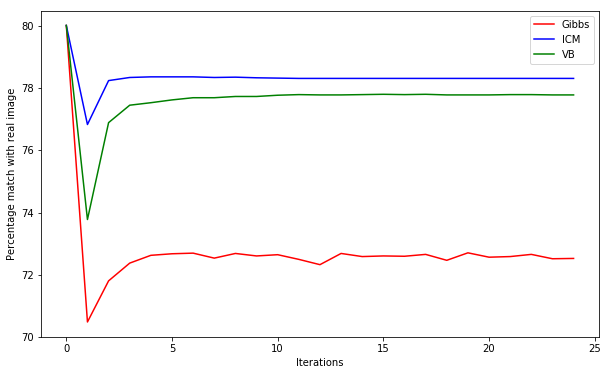

In [123]:
noisyImage = img2
iterate = 25
beta = 0.8
eta = 1

GibbRes  = Gibbs(noisyImage, iterate, beta, eta, 0, img)
denoisedSP = ICM(img2x, iterate)
# denoisedGauss = ICM(img1x, iterate)
VB = meanField(noisyImage, iterate, 1, 1.1, img)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(list(range(iterate)), GibbRes[1]      , c='r', label='Gibbs')
ax.plot(list(range(iterate)), denoisedSP[1], c='b', label='ICM')
ax.plot(list(range(iterate)), VB[2], c='g', label='VB')

ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Percentage match with real image')
plt.savefig('AllComparisonMatchSnP.png')
plt.show()

### Gibb graph drawing

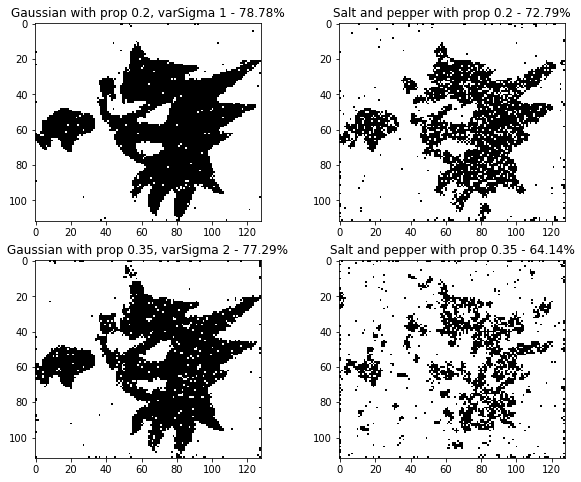

ValueError: x and y must have same first dimension, but have shapes (25,) and (50,)

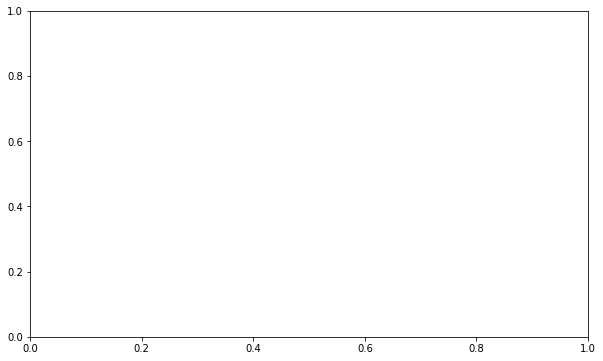

In [411]:
noisyImage = img1
iterate = 25
beta = 0.8
eta = 1

# print('Regular')
# Greg     = Gibbs(noisyImage, iterate, beta, eta, 0, img)
# print('Shuffled')
# Gshuffle = Gibbs(noisyImage, iterate, beta, eta, 1, img)
# print('Fully random')
# Grando   = Gibbs(noisyImage, iterate, beta, eta, 2, img)

# fig = plt.figure(figsize=(8, 8))
# # fig.subplots_adjust(bottom = 0.2, top = 1)
# ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
# ax3 = fig.add_subplot(223)
# ax4 = fig.add_subplot(224)

# ax1.imshow(noisyImage, cmap='gray')
# ax1.set_title('Noisy image')
# ax2.imshow(Greg[0], cmap='gray')
# ax2.set_title('Gibbs, regular order - ' + percentageMatchStr(img, Greg[3]))
# ax3.imshow(Gshuffle[0], cmap='gray')
# ax3.set_title('Gibbs, shuffed order- ' + percentageMatchStr(img, Gshuffle[3]))
# ax4.imshow(Grando[0], cmap='gray')
# ax4.set_title('Gibbs, full random order- ' + percentageMatchStr(img, Grando[3]))
# plt.savefig('HaunterGibbGridGuassian.png')
# plt.show()

# print('Guass normal')
# Ggauss  = Gibbs(img1, iterate, beta, eta, 0, img)
# print('SnP normal')
# GSnP    = Gibbs(img2, iterate, beta, eta, 0, img)
# print('Guass more')
# GgaussM = Gibbs(img1M, iterate, beta, eta, 0, img)
# print('SnP more')
# GSnPM   = Gibbs(img2M, iterate, beta, eta, 0, img)

fig = plt.figure(figsize=(10, 8))
# fig.subplots_adjust(bottom = 0.2, top = 1)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.imshow(Ggauss[0], cmap='gray')
ax1.set_title('Gaussian with prop 0.2, varSigma 1 - ' + percentageMatchStr(img, Ggauss[0]))
ax2.imshow(GSnP[0], cmap='gray')
ax2.set_title('Salt and pepper with prop 0.2 - ' + percentageMatchStr(img, GSnP[0]))
ax3.imshow(GgaussM[0], cmap='gray')
ax3.set_title('Gaussian with prop 0.35, varSigma 2 - ' + percentageMatchStr(img, GgaussM[0]))
ax4.imshow(GSnPM[0], cmap='gray')
ax4.set_title('Salt and pepper with prop 0.35 - ' + percentageMatchStr(img, GSnPM[0]))
plt.savefig('GibbGridDifferentLevels.png')
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(list(range(iterate)), Greg[1], c='r', label='Regular')
plt.plot(list(range(iterate)), Gshuffle[1], c='y', label = 'Shuffled')
plt.plot(list(range(iterate)), Grando[1], c='b', label='Fully random')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Percentage match with real image')
plt.savefig('GibbGuassianMatch.png')
plt.show()

### 2D beta variation

0.5 done
0.56 done
0.62 done
0.68 done
0.74 done
0.8 done
0.8600000000000001 done
0.9200000000000002 done
0.9800000000000001 done
1.04 done


Text(0.5, 0, 'Beta values')

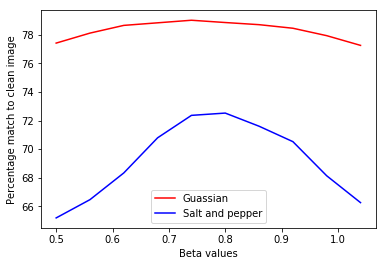

In [362]:
size = 10
maxi = 1.1
mini = 0.5
scaleF = (maxi - mini) / size
results1 = []
results2 = []
betas = []
for i in range(size):
    eta = 1
    iterate = 10
    beta = mini + i * scaleF
    betas.append(beta)
    res1 = Gibbs(img1, iterate, beta, eta, 0, img)[3]
    res2 = Gibbs(img2, iterate, beta, eta, 0, img)[3]
    print(str(beta) + ' done')
    results1.append(percentageMatch(res1, img))
    results2.append(percentageMatch(res2, img))
plt.plot(betas, results1, c='r', label='Guassian')
plt.plot(betas, results2, c='b', label='Salt and pepper')
plt.legend()
plt.ylabel('Percentage match to clean image')
plt.xlabel('Beta values')

### 3D eta beta variaton

In [61]:
size = 50
iterate = 7
maxi = 60
mini = 0
results = np.zeros((size, size))
scaleF = (maxi - mini) / size
etas = []
betas = []
for i in range(size):
    for j in range(size):
        beta = i * scaleF
        eta = j * scaleF
        etas.append(eta)
        betas.append(beta)
        res1 = Gibbs(img2, iterate, beta, eta, 1)[0]
        res2 = Gibbs(img2, iterate, beta, eta, 1)[0]
        results[i, j] = ((percentageMatch(res1, img) + percentageMatch(res2, img) ) / 2)
        perc = 100 * ((size * i) + j)/ (size*size)
        if perc % 2 == 0:
            print(perc)


0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0


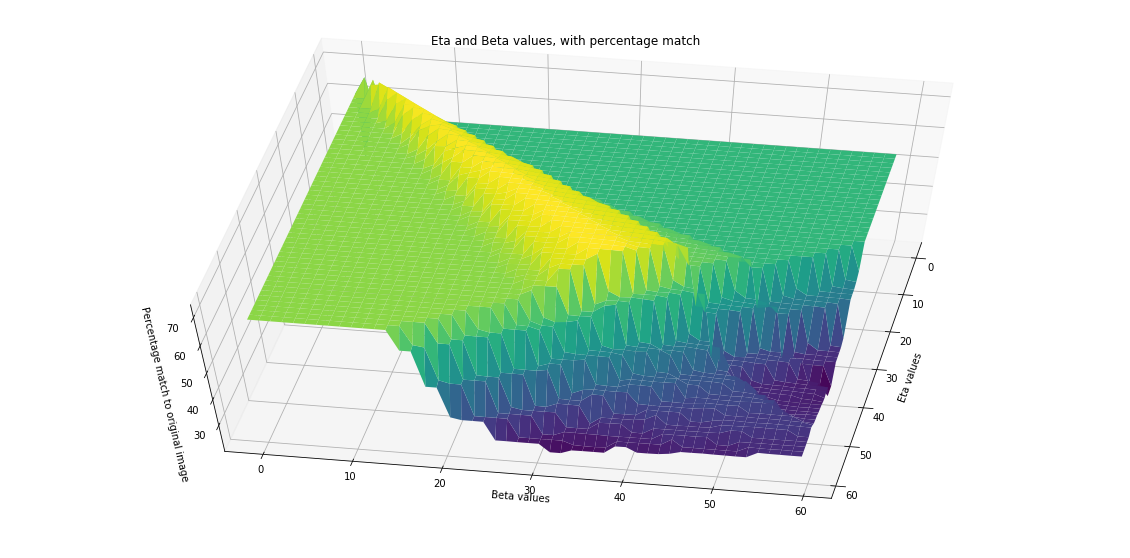

In [78]:
from mpl_toolkits.mplot3d import Axes3D

etas = np.reshape(etas, (size, size))
betas = np.reshape(betas, (size, size))

fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d')
ax.set_title('Eta and Beta values, with percentage match')
ax.set_xlabel('Eta values')
ax.set_ylabel('Beta values')
ax.set_zlabel('Percentage match to original image')
ax.view_init(elev=60, azim=10)
ax.plot_surface(etas, betas, results, cmap='viridis')
plt.savefig('etaBetaDistribution.jpg')

### Variational definiton

In [95]:
def Li2(yi, xi):
    return -abs(xi/2+0.5-yi)*10 + 20

#implementing the ICM algorithm
def meanField(image, t, eta, beta, realIm):
    y = image.copy()
    
    actualImage = image.copy()

    M = np.shape(y)[0]
    N = np.shape(y)[1]

    mu = image.copy()

    m = np.zeros((M,N))

    changes_array = []
    
    cleanSimilarity = []

    for k in range (t):
        
        changes = 0
        cleanSimilarity.append(percentageMatch(actualImage, realIm))
        for i in range (M-1):
            for j in range(N-1):
                
                
                #getting neighbours for the node
                nbrhd = neighbours(i,j,M,N,8)

                #size of neighbourhood
                size = np.shape(nbrhd)[0]

                #initialising array of zeroes
                nbrhd_values = np.zeros(size)

                #Putting values into array
                for l in range(size):
                    nbrhd_values[l] = mu[nbrhd[l]]


                for value in nbrhd_values:
                    m[i,j] += beta * value

                
                mu[i,j] = np.tanh(m[i,j] + 0.5 * eta * (Li2(y[i,j],1) -  Li2(y[i,j],-1)))
        

                if mu[i,j] > 0:
                    if (actualImage[i,j] != 1):
                        changes += 1
                    actualImage[i,j] = 1
                    mu[i,j] = 1
                    
                elif mu[i,j] < 0:
                    if (actualImage[i,j] != 0):
                        changes += 1
                    actualImage[i,j] = 0
                    mu[i,j] = -1
                    

                
        changes_array = np.append(changes_array, changes)

        x = mu.copy()
        y = actualImage.copy()

    return changes_array, y, cleanSimilarity

### VB drawing

In [ ]:
imgPepper2 = add_saltnpepper_noise(img, 0.2)
imgPepper35 = add_saltnpepper_noise(img, 0.35)

imgG2_1 = add_gaussian_noise(img, 0.1, 0.1)
imgG35_2 = add_gaussian_noise(img, 0.35, 0.2)

fig = plt.figure(figsize = (12, 10))
fig.subplots_adjust(bottom = 0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.imshow(meanField(imgG2_1, 1, 1,1)[1], cmap = 'gray')
ax1.set_title('Gaussian with prop 0.2, var 0.1 -' + percentageMatchStr(img, meanField(imgG2_1, 1, 1,1)[1]))
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(meanField(imgPepper2, 3, 1,0.6)[1], cmap = 'gray')
ax2.set_title('Salt and Pepper with prop 0.2 - ' + percentageMatchStr(img, meanField(imgPepper2, 3, 1,1)[1]))
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(meanField(imgG35_2, 2, 1,1)[1], cmap = 'gray')
ax3.set_title('Gaussian with prop 0.35, var 0.2 - ' + percentageMatchStr(img, meanField(imgG35_2, 2, 1,1)[1]))
ax3.set_xticks([])
ax3.set_yticks([])

ax4.imshow(meanField(imgPepper35, 3, 1,1)[1], cmap = 'gray')
ax4.set_title('Salt and Pepper with prop 0.35 - ' + percentageMatchStr(img, meanField(imgPepper35, 3, 1,1)[1]))
ax4.set_xticks([])
ax4.set_yticks([])

plt.savefig("variationBayes.png")